In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

### Load dataset

In [ ]:
imdb_subwords, info_subwords = tfds.load("imdb_reviews/subwords8k", with_info=True, as_supervised=True)

print(info_subwords)

print("############ Encoded ############")
for x in imdb_subwords["train"].take(2):
    print(x)

print("############ Decoded ############")
encoder_im = info_subwords.features["text"].encoder
for x in imdb_subwords["train"].take(2):
    print(encoder_im.decode(x[0]))
    print("========")
    
print("###################################")
print("Vocab Size of Subword Text Encoding = ",encoder_im.vocab_size)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete29PSGH/imdb_reviews-train.tfrecord*...…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete29PSGH/imdb_reviews-test.tfrecord*...:…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete29PSGH/imdb_reviews-unsupervised.tfrec…

Dataset imdb_reviews downloaded and prepared to ~/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/subwords8k/1.0.0',
    description="""
    Large Movie Review Dataset.
    This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Uses `tfds.deprecated.text.SubwordTextEncoder` with 8k vocab size
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_path='~/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0',
    file_format=tfrecord,
    download_size=80.23 MiB,
    dataset_size=54.72 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text':

In [ ]:
print(info_subwords.splits)
print(info_subwords.features)

{Split('train'): <SplitInfo num_examples=25000, num_shards=1>, Split('test'): <SplitInfo num_examples=25000, num_shards=1>, Split('unsupervised'): <SplitInfo num_examples=50000, num_shards=1>}
FeaturesDict({
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'text': Text(shape=(None,), dtype=tf.int64, encoder=<SubwordTextEncoder vocab_size=8185>),
})


In [ ]:
imdb_subwords_train_ds = imdb_subwords["train"]
imdb_subwords_train_ds = imdb_subwords_train_ds.shuffle(buffer_size=25000)
imdb_subwords_train_ds = imdb_subwords_train_ds.padded_batch(batch_size=256) #Bigger batch (256) for LSTM. ELse 64

imdb_subwords_test_ds = imdb_subwords["test"]
imdb_subwords_test_ds = imdb_subwords_test_ds.padded_batch(batch_size=256) #Bigger batch (256) for LSTM. ELse 64

In [ ]:
def plot_graphs(model_hist, string):
  plt.plot(model_hist.history[string])
  plt.plot(model_hist.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

## RNN

- There are three built-in RNN layers in Keras: ``keras.layers.SimpleRNN``, ``GRU``, ``LSTM``
- Bidirectional RNNs : For sequences other than time series (e.g. text), it is often the case that a RNN model can perform better if it not only processes sequence from start to end, but also backwards. For example, to predict the next word in a sentence, it is often useful to have the context around the word, not only just the words that come before it
- Gated Recurrent Unit or GRU is usually referred to as a simpler version of the LSTM. It can be used in applications where the sequence is important but you want faster results and can sacrifice some accuracy
- You can build multiple layer LSTM models by simply appending another LSTM layer in your Sequential model and enabling the return_sequences flag to True. This is because an LSTM layer expects a sequence input so if the previous layer is also an LSTM, then it should output a sequence as well
  - By default, return_sequences=False i.e., whether to return the last output in the output sequence, or the full sequence.

### GRU

In [ ]:
imdb_subwords_gru_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=encoder_im.vocab_size,output_dim=64),

    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=64)), #activation='tanh'

    tf.keras.layers.Dense(units=16,activation='relu'),
    tf.keras.layers.Dense(units=1,activation='sigmoid')
])

imdb_subwords_gru_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

imdb_subwords_gru_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          523840    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              49920     
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 16)                2064      
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 575,841
Trainable params: 575,841
Non-trainable params: 0
_________________________________________________________________


In [ ]:
imdb_subwords_gru_model_hist = imdb_subwords_gru_model.fit(imdb_subwords_train_ds,
                                                             epochs=10,
                                                             validation_data=imdb_subwords_test_ds)

Epoch 1/10
98/98 [==============================] - 28s 240ms/step - loss: 0.6361 - accuracy: 0.6074 - val_loss: 0.4951 - val_accuracy: 0.7624
Epoch 2/10
98/98 [==============================] - 26s 261ms/step - loss: 0.3684 - accuracy: 0.8469 - val_loss: 0.4403 - val_accuracy: 0.7998
Epoch 3/10
98/98 [==============================] - 22s 215ms/step - loss: 0.2783 - accuracy: 0.8942 - val_loss: 0.3703 - val_accuracy: 0.8494
Epoch 4/10
98/98 [==============================] - 21s 214ms/step - loss: 0.2331 - accuracy: 0.9164 - val_loss: 0.3837 - val_accuracy: 0.8402
Epoch 5/10
98/98 [==============================] - 21s 215ms/step - loss: 0.1965 - accuracy: 0.9307 - val_loss: 0.4059 - val_accuracy: 0.8513
Epoch 6/10
98/98 [==============================] - 23s 235ms/step - loss: 0.2234 - accuracy: 0.9153 - val_loss: 0.4219 - val_accuracy: 0.8364
Epoch 7/10
98/98 [==============================] - 23s 227ms/step - loss: 0.1713 - accuracy: 0.9386 - val_loss: 0.4446 - val_accuracy: 0.8497

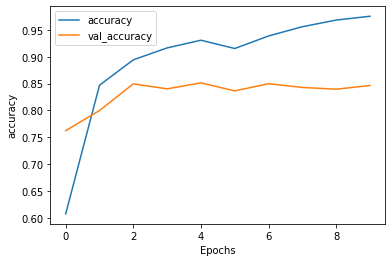

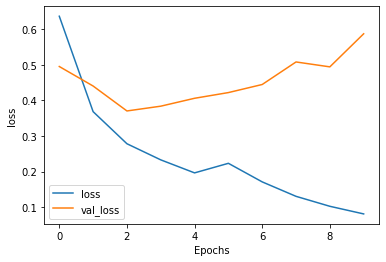

In [ ]:
plot_graphs(imdb_subwords_gru_model_hist, "accuracy")
plot_graphs(imdb_subwords_gru_model_hist, "loss")

### Single-layer LSTM

In [ ]:
imdb_subwords_single_lstm_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=encoder_im.vocab_size,output_dim=64),

    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64)), #activation='tanh'
    
    tf.keras.layers.Dense(units=64,activation='relu'),
    tf.keras.layers.Dense(units=1,activation='sigmoid')
])

imdb_subwords_single_lstm_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

imdb_subwords_single_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          523840    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 598,209
Trainable params: 598,209
Non-trainable params: 0
_________________________________________________________________


In [ ]:
imdb_subwords_single_lstm_model_hist = imdb_subwords_single_lstm_model.fit(imdb_subwords_train_ds,
                                                             epochs=10,
                                                             validation_data=imdb_subwords_test_ds)

Epoch 1/10
98/98 [==============================] - 34s 257ms/step - loss: 0.6104 - accuracy: 0.6596 - val_loss: 0.5004 - val_accuracy: 0.7631
Epoch 2/10
98/98 [==============================] - 24s 245ms/step - loss: 0.3478 - accuracy: 0.8568 - val_loss: 0.4112 - val_accuracy: 0.8216
Epoch 3/10
98/98 [==============================] - 27s 274ms/step - loss: 0.2517 - accuracy: 0.9047 - val_loss: 0.4255 - val_accuracy: 0.8105
Epoch 4/10
98/98 [==============================] - 26s 265ms/step - loss: 0.1927 - accuracy: 0.9310 - val_loss: 0.4008 - val_accuracy: 0.8447
Epoch 5/10
98/98 [==============================] - 26s 260ms/step - loss: 0.1532 - accuracy: 0.9479 - val_loss: 0.4498 - val_accuracy: 0.8443
Epoch 6/10
98/98 [==============================] - 27s 274ms/step - loss: 0.1161 - accuracy: 0.9605 - val_loss: 0.4962 - val_accuracy: 0.8341
Epoch 7/10
98/98 [==============================] - 25s 251ms/step - loss: 0.1051 - accuracy: 0.9640 - val_loss: 0.5369 - val_accuracy: 0.8300

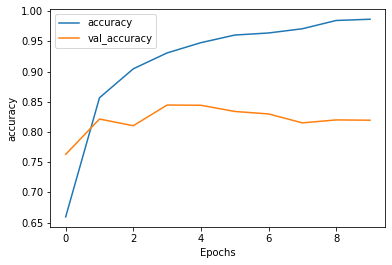

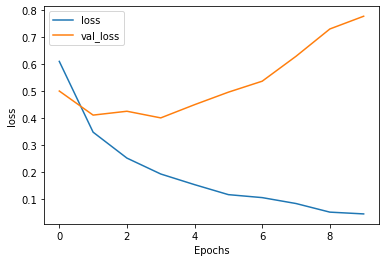

In [ ]:
plot_graphs(imdb_subwords_single_lstm_model_hist, "accuracy")
plot_graphs(imdb_subwords_single_lstm_model_hist, "loss")

### Multi-layer LSTM

In [ ]:
imdb_subwords_multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=encoder_im.vocab_size,output_dim=64),

    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64,return_sequences=True)), #activation='tanh'
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=32)), #activation='tanh'

    tf.keras.layers.Dense(units=64,activation='relu'),
    tf.keras.layers.Dense(units=1,activation='sigmoid')
])

imdb_subwords_multi_lstm_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

imdb_subwords_multi_lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          523840    
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 128)        66048     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 635,329
Trainable params: 635,329
Non-tr

In [ ]:
imdb_subwords_multi_lstm_model_hist = imdb_subwords_multi_lstm_model.fit(imdb_subwords_train_ds,
                                                             epochs=10,
                                                             validation_data=imdb_subwords_test_ds)

Epoch 1/10
98/98 [==============================] - 53s 484ms/step - loss: 0.5892 - accuracy: 0.6708 - val_loss: 0.4904 - val_accuracy: 0.7887
Epoch 2/10
98/98 [==============================] - 44s 448ms/step - loss: 0.3490 - accuracy: 0.8577 - val_loss: 0.3997 - val_accuracy: 0.8266
Epoch 3/10
98/98 [==============================] - 46s 458ms/step - loss: 0.2630 - accuracy: 0.8997 - val_loss: 0.3882 - val_accuracy: 0.8422
Epoch 4/10
98/98 [==============================] - 45s 452ms/step - loss: 0.2193 - accuracy: 0.9174 - val_loss: 0.4318 - val_accuracy: 0.8451
Epoch 5/10
98/98 [==============================] - 44s 447ms/step - loss: 0.1561 - accuracy: 0.9456 - val_loss: 0.4356 - val_accuracy: 0.8192
Epoch 6/10
98/98 [==============================] - 44s 444ms/step - loss: 0.1193 - accuracy: 0.9610 - val_loss: 0.4810 - val_accuracy: 0.8329
Epoch 7/10
98/98 [==============================] - 45s 449ms/step - loss: 0.0936 - accuracy: 0.9703 - val_loss: 0.5711 - val_accuracy: 0.8334

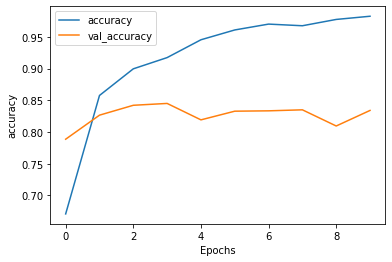

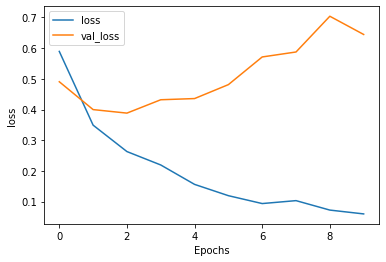

In [ ]:
plot_graphs(imdb_subwords_multi_lstm_model_hist, "accuracy")
plot_graphs(imdb_subwords_multi_lstm_model_hist, "loss")

## CNN

In [ ]:
imdb_subwords_cnn_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=encoder_im.vocab_size,output_dim=64),
    
    tf.keras.layers.Conv1D(filters=128,kernel_size=5,activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),

    tf.keras.layers.Dense(units=64,activation='relu'),
    tf.keras.layers.Dense(units=1,activation='sigmoid')
])

imdb_subwords_cnn_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

imdb_subwords_cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          523840    
                                                                 
 conv1d (Conv1D)             (None, None, 128)         41088     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 573,249
Trainable params: 573,249
Non-trainable params: 0
__________________________________________________

In [ ]:
imdb_subwords_cnn_model_hist = imdb_subwords_cnn_model.fit(imdb_subwords_train_ds,
                                                             epochs=10,
                                                             validation_data=imdb_subwords_test_ds)

Epoch 1/10
98/98 [==============================] - 48s 394ms/step - loss: 0.6258 - accuracy: 0.6479 - val_loss: 0.4272 - val_accuracy: 0.8073
Epoch 2/10
98/98 [==============================] - 17s 165ms/step - loss: 0.2910 - accuracy: 0.8795 - val_loss: 0.2661 - val_accuracy: 0.8878
Epoch 3/10
98/98 [==============================] - 13s 122ms/step - loss: 0.1443 - accuracy: 0.9509 - val_loss: 0.2632 - val_accuracy: 0.8912
Epoch 4/10
98/98 [==============================] - 13s 127ms/step - loss: 0.0608 - accuracy: 0.9871 - val_loss: 0.2880 - val_accuracy: 0.8913
Epoch 5/10
98/98 [==============================] - 11s 112ms/step - loss: 0.0201 - accuracy: 0.9984 - val_loss: 0.3148 - val_accuracy: 0.8932
Epoch 6/10
98/98 [==============================] - 11s 108ms/step - loss: 0.0067 - accuracy: 0.9999 - val_loss: 0.3428 - val_accuracy: 0.8926
Epoch 7/10
98/98 [==============================] - 9s 91ms/step - loss: 0.0033 - accuracy: 0.9999 - val_loss: 0.3613 - val_accuracy: 0.8924
E

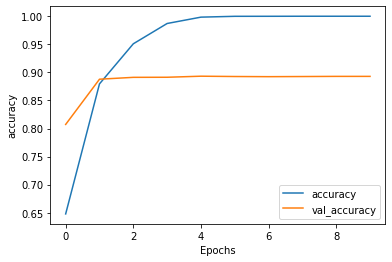

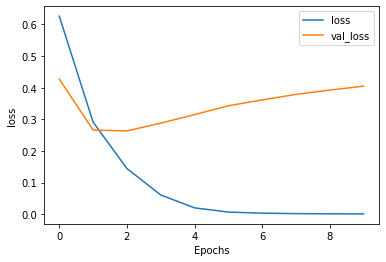

In [ ]:
plot_graphs(imdb_subwords_cnn_model_hist, "accuracy")
plot_graphs(imdb_subwords_cnn_model_hist, "loss")